In [2]:
#base packages
import math, os, scipy, h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
import pandas as pd
from dotenv import load_dotenv 
from tldextract import extract


#tensorflow
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras import preprocessing
import tensorflow_datasets as tfds
import tensorflow_text as text

import matplotlib.pyplot as plt
%matplotlib inline
  
    


In [3]:
#!pip install tensorflow_datasets
#!pip install tensorflow-text
#!pip install tldextract

### global configurations

In [4]:
tf.executing_eagerly()

EMBED_SIZE=20

### load data from database

In [5]:
load_dotenv() 
usrname = os.getenv('MYSQL_USER')
passwd = os.getenv('MYSQL_PASSWORD')
dbname = os.getenv('MYSQL_DB')

connectstring = "mysql://"+usrname+ ":"+passwd+"@localhost/"+dbname+"?charset=utf8"

from sqlalchemy import create_engine
dbengine = create_engine(connectstring,encoding="utf8")


In [37]:
#Load #phishnet database
#use the DB/ This is only for you.

def load_url_data():
  
    
    myQuery = '''select tmp1.url,if(click.clicked_dt is null, tmp1.y, 2) as y  from 
                (SELECT url, 1 as y FROM ternary_fund.redditdata
                 union select url, 1 as y from RecNet.reddit_urls where domain != "i.redd.it"
                 union select url, 0 as y from RecNet.phishing_data) as tmp1

                left join RecNet.click_data as click on
                MD5(tmp1.url) = MD5(click.url)
                
                order by rand();
                '''
    df = pd.read_sql_query(myQuery, dbengine)
    
    return df

#Pandas dataframe
df = load_url_data()
print("Number of observations " +str(len(df.index)))
grouped_df=df.groupby(['y'])['y']

print(grouped_df.describe())
    
df = df.drop_duplicates()
y_data = df['y'].to_numpy()


Number of observations 17865
     count  mean  std  min  25%  50%  75%  max
y                                             
0  15963.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1   1761.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
2    141.0   2.0  0.0  2.0  2.0  2.0  2.0  2.0


### Tokenize the URL


In [38]:
#URL tokenizer
#INPUT  : A utf-8 encoded URL String
#OUTOUT : A dict of tokens

def getTokens(urlinput):
    tokensBySlash=str(urlinput.encode('utf-8')).split('/')
    allTokens = []
    for i in tokensBySlash:
        tokens = str(i).split('-')
        tokensByDot=[]
        for j in range(0,len(tokens)):
            tempTokens = str(tokens[j]).split('.')
            tokensByDot = tokensByDot + tempTokens
        allTokens=allTokens+tokens+tokensByDot
    allTokens = list(set(allTokens))
    
    if 'com' in allTokens:
        allTokens.remove('com')
        
    return allTokens

In [39]:
def getTokens_into_characters(urlinput):
    tokensBySlash=' '.join(str(urlinput.encode('utf-8')).strip("'").strip("b'")).split('/')
    #print(tokensBySlash)
    allTokens = []
    for i in tokensBySlash:
        tokens = str(i).split('-')
        #print("*** splitting by dash ***")
        #print(tokens)
        tokensByDot=[]
        for j in range(0,len(tokens)):
            #print(str(tokens[j]).split('.'))
            tokensByDot += str(tokens[j]).split('.')
            #print("*** splitting by dot ***")
            #print(tokensByDot)
        allTokens+=tokensByDot
    allTokens = ' '.join(list(allTokens)).split() 
    
    #print(allTokens)
    #if 'com' in allTokens:
    #    allTokens.remove('com')
       
    return allTokens

In [40]:
def getTokens_into_words(urlinput):
    tokensBySlash=str(urlinput.encode('utf-8')).strip("'").strip("b'").split('/')
    #print(tokensBySlash)
    allTokens = []
    for i in tokensBySlash:
        tokens = str(i).split('-')
        #print("*** splitting by dash ***")
        #print(tokens)
        tokensByDot=[]
        for j in range(0,len(tokens)):
            #print(str(tokens[j]).split('.'))
            tokensByDot += str(tokens[j]).split('.')
            #print("*** splitting by dot ***")
            #print(tokensByDot)
        allTokens+=tokensByDot
    allTokens = ' '.join(list(allTokens)).split() 
    
    #print(allTokens)
    #if 'com' in allTokens:
    #    allTokens.remove('com')
       
    return allTokens

In [41]:
def getURLInfo(url):
    #some idea to extract only once
    val = extract(url)
    a = val.domain
    b = val.suffix
    
    return a,b

In [42]:
tokenized_url_word = df.apply(lambda row:getTokens_into_words(row['url']), axis=1)
df.insert(len(df.columns), 'tokenized_url_word',tokenized_url_word )

tokenized_url_char= df.apply(lambda row:getTokens_into_characters(row['url']), axis=1)
df.insert(len(df.columns), 'tokenized_url_char',tokenized_url_char )

tld= df.apply(lambda row:extract(row['url']).suffix, axis=1)
df.insert(len(df.columns), 'tld',tld )

domain = df.apply(lambda row:extract(row['url']).domain, axis=1)
df.insert(len(df.columns), 'domain',domain )



In [43]:
#This is for testing the tokenization effort  ; commented out since it works
#df[['tokenized_url_word','url','domain','tld']].to_csv('tokenized-result.csv')   
#what does that really measure?
#val= df.tokenized_url_word.map(len).max()
#print("Longest vector with words " + str(val))

#focus embeddings!

### Encode the URL from text sequences to integers per vocabulary

In [65]:
from tensorflow.keras.preprocessing.text import Tokenizer

tf_keras_tokenizer = Tokenizer()
tf_keras_tokenizer.fit_on_texts(df['tokenized_url_word'])
tf_keras_encoded = tf_keras_tokenizer.texts_to_sequences(df['tokenized_url_word'])
tf_keras_encoded = preprocessing.sequence.pad_sequences(tf_keras_encoded, padding="post", maxlen=EMBED_SIZE) 
print(tf_keras_encoded.shape)

print("*** sample check ***")
print(df['url'][100])
print(df['tokenized_url_word'][100])
print(tf_keras_encoded[100] )

print(df['url'][200])
print(df['tokenized_url_word'][200])
print(tf_keras_encoded[200] )

(17796, 20)
*** sample check ***
http://granhongo.com/wp-includes/Login/customer_center/customer-IDPP00C824/myaccount/identity/?cmd=_session=US&amp;;0595c7a41dc9fe6ff5c81eb916bf2461&amp;;dispatch=3ca119e0036f5dd52757270e38d3b0322f965418
['http:', 'granhongo', 'com', 'wp', 'includes', 'Login', 'customer_center', 'customer', 'IDPP00C824', 'myaccount', 'identity', '?cmd=_session=US&amp;;0595c7a41dc9fe6ff5c81eb916bf2461&amp;;dispatch=3ca119e0036f5dd52757270e38d3b0322f965418']
[   3  766    1    5   19    6   62   61  767   44  165 9384    0    0
    0    0    0    0    0    0]
https://paypal-paiement.nhx.fr/myaccount/signin/?country.x=US&locale.x=en_US
['https:', 'paypal', 'paiement', 'nhx', 'fr', 'myaccount', 'signin', '?country', 'x=US&locale', 'x=en_US']
[   2   29 2237 2238   65   44   51  172  438  285    0    0    0    0
    0    0    0    0    0    0]


In [45]:
tf_keras_tokenizer.index_word[5000]  

'resbetsgiris'

In [46]:
#Apply the Q-learning approach
#We have now a tokenized representation of the url
#Next step token to integer
#then integer to sense vector (the embedding)

In [47]:
#print(max(encoded_urls))
print(max(tf_keras_tokenizer.index_word ) )



28892


### Embedding layers
An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters 
(weights learned by the model during training, in the same way a model learns weights for a dense layer). 
It is common to see word embeddings that are 8-dimensional (for small datasets),
up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained
relationships between words, but takes more data to learn.

The Embedding layer can be understood as a lookup table that maps from integer indices 
(which stand for specific words) to dense vectors (their embeddings).
The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.


In [48]:

VOCAB_LEN = max(tf_keras_tokenizer.index_word ) +1
print(VOCAB_LEN)

embedding_layer = layers.Embedding(VOCAB_LEN, EMBED_SIZE)

result = embedding_layer(tf_keras_encoded)
#result.numpy()

#Voila, now I have a list of tokenized, vocabbed, and embedded words. 
#Happiness arises

print(result.shape)
print(type(result))
print(result[5000]) #should be a EMBED_SIZE x EMBED_SIZE expression of 'revolut'

28893
(17796, 20, 20)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[-0.04289266 -0.00011485 -0.03722057 -0.00737196  0.01851607 -0.00184865
   0.02960584 -0.01173165  0.03141943  0.03511794 -0.01993811 -0.00697229
  -0.03550835  0.00446681 -0.03122972  0.02155412 -0.03519147  0.02166437
   0.03360565 -0.01395231]
 [ 0.02416639  0.0296557   0.04601595 -0.01289277 -0.00420254  0.02007831
  -0.01219572  0.02458297 -0.02216781  0.02697629  0.03359176  0.01349349
   0.02408506 -0.02799667 -0.01883093  0.04949525  0.04161314  0.03738426
  -0.00542581  0.00059676]
 [-0.03191575 -0.02857597 -0.01868967 -0.01617435 -0.02658081  0.01693271
  -0.00324436  0.02405324 -0.03087668 -0.03921938  0.0367818   0.03327987
  -0.04473532 -0.03911715  0.04092145  0.00955772 -0.00455239  0.02874171
   0.00863316 -0.01248695]
 [-0.00726358 -0.02659889 -0.01468716  0.01620622 -0.02090106 -0.03192788
  -0.02999078  0.00549091  0.0004215  -0.00162289 -0.04431893 -0.03534098
   0.02901215  0.0

When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table:

or text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape (samples, sequence_length), where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes (32, 10) (batch of 32 sequences of length 10) or (64, 15) (batch of 64 sequences of length 15).

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a (2, 3) input batch and the output is (2, 3, N)

In [49]:
#Split the generates tf_keras_encoded dataset (result) into training and testing
#DATASET_SIZE = result.shape[0]


dataset = tf.data.Dataset.from_tensor_slices((result, y_data))
dataset.shuffle(buffer_size=1024)
#.batch(32)

result2 = tf.reshape(result, (-1, EMBED_SIZE, EMBED_SIZE,1))
y_data2 = tf.reshape(y_data, (-1, 1))

print(result.shape)
print(result2.shape)
print(y_data.shape)
print(y_data2.shape)

print(type(result))
print(type(result2))

print(y_data2)

(17796, 20, 20)
(17796, 20, 20, 1)
(17796,)
(17796, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]], shape=(17796, 1), dtype=int64)


In [50]:
#hardcode the validation sample at 3000
#not good practice, but hey, here we are

print(result2.shape[0])
cutoff=int(result2.shape[0]*-0.25)
print(str(cutoff))

x_val = result2[cutoff:]
y_val = y_data2[cutoff:]
x_train = result2[:cutoff]
y_train = y_data2[:cutoff]

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

17796
-4449
(13347, 20, 20, 1)
(13347, 1)
(4449, 20, 20, 1)
(4449, 1)


### Word based model

In [51]:
#256 h-length convolutional filters 3,4,5,6 - for WORD level
wordmodel = models.Sequential()
wordmodel.add(layers.Conv2D(filters=256,kernel_size=(3, 3), strides= (1, 1), padding='same', activation='relu', input_shape=(EMBED_SIZE, EMBED_SIZE, 1)))
wordmodel.add(layers.MaxPooling2D((2, 2)))
wordmodel.add(layers.Dense(512, activation='relu'))


In [52]:
wordmodel.add(layers.Flatten())
wordmodel.add(layers.Dense(512, activation='relu'))
wordmodel.add(layers.Dense(256, activation='relu'))
wordmodel.add(layers.Dense(128, activation='relu'))
wordmodel.add(layers.Dense(3))

In [60]:
wordmodel.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

#wordmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [61]:
wordmodel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 20, 20, 256)       2560      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 256)       0         
_________________________________________________________________
dense_10 (Dense)             (None, 10, 10, 512)       131584    
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               26214912  
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_13 (Dense)             (None, 128)              

In [62]:
#Reminder change the epoch if needed it was 10
#Why you need the epoch anyways...

history = wordmodel.fit(x_train, y_train, epochs=10, validation_split=0.1, verbose=1)



Epoch 1/10
376/376 [==============================] - 122s 325ms/step - loss: 1.6572 - accuracy: 0.8972 - val_loss: 1.6541 - val_accuracy: 0.8974
Epoch 2/10
376/376 [==============================] - 121s 322ms/step - loss: 1.6572 - accuracy: 0.8972 - val_loss: 1.6541 - val_accuracy: 0.8974
Epoch 3/10
376/376 [==============================] - 116s 308ms/step - loss: 1.6572 - accuracy: 0.8972 - val_loss: 1.6541 - val_accuracy: 0.8974
Epoch 4/10
153/376 [===========>..................] - ETA: 1:07 - loss: 1.7053 - accuracy: 0.8942

KeyboardInterrupt: 

In [56]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = wordmodel.evaluate(x_val,y_val, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = wordmodel.predict(x_val[:3])
print("predictions shape:", predictions.shape)

print(predictions)

Evaluate on test data
35/35 [==============================] - 7s 202ms/step - loss: 1.6701 - accuracy: 0.8964
test loss, test acc: [1.670137643814087, 0.8963811993598938]
Generate predictions for 3 samples
predictions shape: (3, 3)
[[ 2.6192245  -0.11465917 -0.16166943]
 [ 2.6192782  -0.11466367 -0.16098382]
 [ 2.6187303  -0.1142107  -0.1623353 ]]


### Compiling and fitting the models

In [57]:
wordmodel.metrics_names

['loss', 'accuracy']

557/557 - 36s - loss: 1.6602 - accuracy: 0.8970


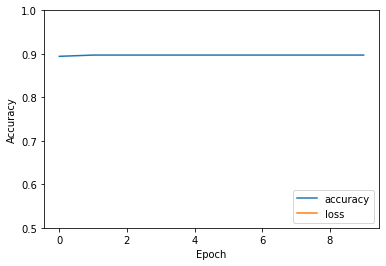

In [58]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = wordmodel.evaluate(result2,  y_data2, verbose=2)


In [59]:
print(test_acc)


0.8969992995262146
